# Variants of concern in Canada
*April 21, 2022*

This week, a graphic was requested showing variants and their rise and fall overtime. This data exists on Public Health Agency of Canada's website [here](https://health-infobase.canada.ca/covid-19/epidemiological-summary-covid-19-cases.html#VOC).

We start by importing pandas.

In [167]:
import pandas as pd

Then read in the data directly from the source and take a quick peek at the structure.

In [168]:
raw = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-epiSummary-variants.csv")

raw.head()

,Variant Grouping,_Identifier,Lineage Grouped,%CT Count of Sample #,Collection (week)
0,VOC,Alpha,B.1.1.7 (Alpha),0.001,2020-04-05
1,VOC,Alpha,B.1.1.7 (Alpha),0.001,2020-04-19
2,VOC,Alpha,B.1.1.7 (Alpha),0.008,2020-05-10
3,VOC,Alpha,B.1.1.7 (Alpha),0.008,2020-05-17
4,VOC,Alpha,B.1.1.7 (Alpha),0.002,2020-05-31


Now, we'll pivot this so we have a nice series to plot.

In [169]:
pivot = raw.pivot_table(columns=["_Identifier"], index="Collection (week)", values="%CT Count of Sample #", aggfunc="sum")

pivot.head()

_Identifier,Alpha,Beta,Delta,Eta,Gamma,Omicron,Other
Collection (week),,,,,,,
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN,1.0


For most of these variants, we just want to include data for the variant as is (the _Identifier column). But for Omicron, we want more detailed data. Let's break out Omicron using a separate analysis. First, we'll get just our omicron rows from the raw dataset.

In [170]:
omicron = raw[raw["_Identifier"] == "Omicron"]

Let's see what values Omicron is grouped into.

In [171]:
omicron["Lineage Grouped"].unique()

array(['BA.1', 'BA.1.1', 'BA.2', 'BA.2.2', 'Other Omicron'], dtype=object)

There are four variants here, plus an "Other omicron" category.

In [172]:
omicron.loc[:, "Lineage Grouped"] = (omicron
                              .loc[:, "Lineage Grouped"]
                              )

omicron.head()

C:\Users\dexmc\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Variant Grouping,_Identifier,Lineage Grouped,%CT Count of Sample #,Collection (week)
567,VOC,Omicron,BA.1,0.002,2021-11-21
568,VOC,Omicron,BA.1,0.011,2021-11-28
569,VOC,Omicron,BA.1,0.110,2021-12-05
570,VOC,Omicron,BA.1,0.286,2021-12-12
571,VOC,Omicron,BA.1,0.458,2021-12-19


Now, we'll use groupby and sum to consolidate our omicron values together, just like we did for all the other variants above. We'll join onto the other table shortly.

In [173]:
omicron = (omicron
           .groupby(["Lineage Grouped", "Collection (week)"]).sum()
           .reset_index()
           .pivot(index="Collection (week)", columns="Lineage Grouped", values="%CT Count of Sample #")
           )

We're also going to rename these so they're a little cleaner, before we join onto the other table.

In [174]:
omicron.columns = "Omicron - " + omicron.columns

Now, we'll drop some variants we don't care too much about (and also the Omicron aggregate column), join on our new omicron breakdowns, and do some renaming of columns for clarity.

In [175]:
pivot = (pivot
         .drop(columns=["Omicron", "Eta", "Beta"])
         .join(omicron).loc[pivot.index >= "2020-12-10", :]
         )

We'll also multiple by 100 so we get real percentages and can visualize it more clearly.

In [176]:
pivot = pivot * 100

pivot

,Alpha,Delta,Gamma,Other,Omicron - BA.1,Omicron - BA.1.1,Omicron - BA.2,Omicron - BA.2.2,Omicron - Other Omicron
Collection (week),,,,,,,,,
2020-12-13,0.4,NaN,NaN,99.3,NaN,NaN,NaN,NaN,NaN
2020-12-20,0.4,NaN,NaN,99.2,NaN,NaN,NaN,NaN,NaN
2020-12-27,1.3,0.1,NaN,98.4,NaN,NaN,NaN,NaN,NaN
2021-01-03,1.4,NaN,NaN,97.8,NaN,NaN,NaN,NaN,NaN
2021-01-10,2.5,NaN,0.1,96.4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-02-27,NaN,0.1,NaN,0.2,11.3,46.1,23.1,0.0,19.2
2022-03-06,NaN,NaN,NaN,NaN,8.8,41.5,30.1,0.1,19.6
2022-03-13,NaN,NaN,NaN,NaN,4.1,38.4,34.1,0.0,23.4


Let's plot it using pandas before we take it over to datawrapper for the public-facing version.

<AxesSubplot:xlabel='Collection (week)'>

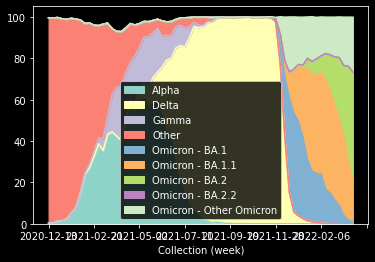

In [177]:
pivot.plot.area()

You can view the public facing, Datawrapper version [here](https://www.datawrapper.de/_/mqQzc/).

\-30\-